In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Define paths
train_dir = 'Teeth_Dataset/Training'
val_dir = 'Teeth_Dataset/Validation'
test_dir = 'Teeth_Dataset/Testing'

In [8]:
# Function to load and preprocess images
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [9]:
# Function to get label from path
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == class_names

In [10]:
# Function to load and preprocess dataset
def load_and_preprocess_dataset(directory):
    list_ds = tf.data.Dataset.list_files(str(directory + '/*/*'))
    labeled_ds = list_ds.map(lambda x: (load_and_preprocess_image(x), get_label(x)))
    return labeled_ds

In [11]:
# Get class names
class_names = np.array(sorted([item.name for item in os.scandir(train_dir) if item.is_dir()]))


In [12]:
# Load datasets
train_ds = load_and_preprocess_dataset(train_dir)
val_ds = load_and_preprocess_dataset(val_dir)
test_ds = load_and_preprocess_dataset(test_dir)

# Batch and shuffle datasets
train_ds = train_ds.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,566,151 (36.49 MB)

 Trainable params: 9,565,703 (36.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.2480 - loss: 7.5222 - val_accuracy: 0.1449 - val_loss: 32.3880
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3099 - loss: 1.8525 - val_accuracy: 0.1449 - val_loss: 47.5334
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3363 - loss: 1.8393 - val_accuracy: 0.1527 - val_loss: 24.4792
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3638 - loss: 1.6836 - val_accuracy: 0.2782 - val_loss: 10.6157
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3664 - loss: 1.6205 - val_accuracy: 0.3016 - val_loss: 2.9173
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.3788 - loss: 1.5778 - val_accuracy: 0.4280 - val_loss: 1.6054
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.4417 - loss: 1.4685 - val_accuracy: 0.2733 - val_loss: 1.7882
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4586 - loss: 1.3577 - val_accuracy: 0.3881 

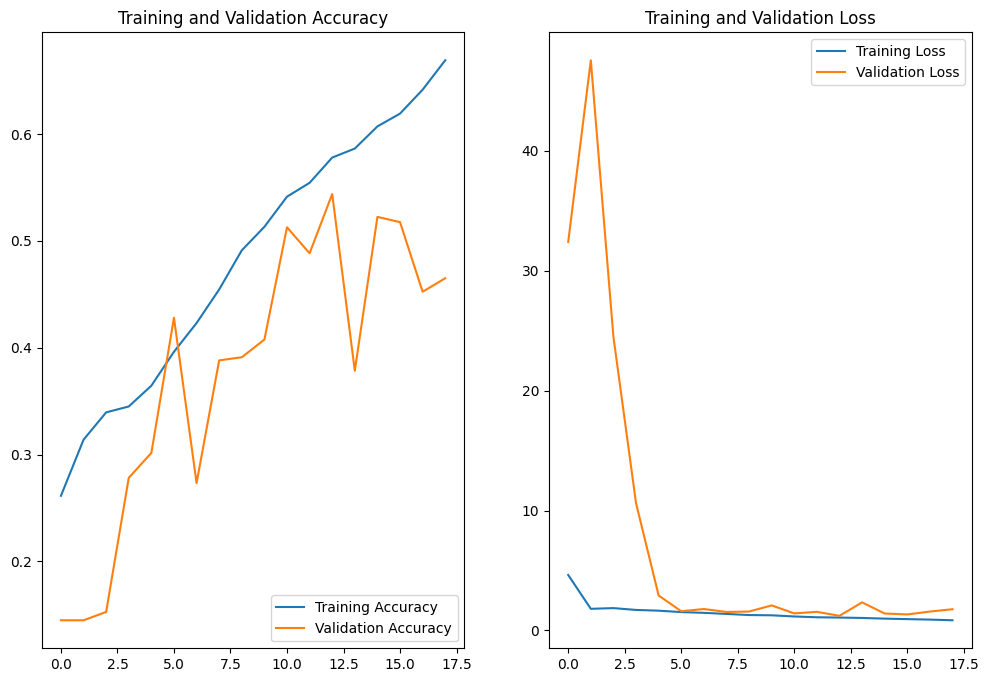

In [14]:

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)